### Setup

In [ ]:
import pandas as pd
from pathlib import Path

fpath = Path("../RetailSalesPrediction/us_retail_sales.csv")
df = pd.read_csv(fpath)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    30 non-null     int64  
 1   JAN     30 non-null     int64  
 2   FEB     30 non-null     int64  
 3   MAR     30 non-null     int64  
 4   APR     30 non-null     int64  
 5   MAY     30 non-null     int64  
 6   JUN     30 non-null     int64  
 7   JUL     29 non-null     float64
 8   AUG     29 non-null     float64
 9   SEP     29 non-null     float64
 10  OCT     29 non-null     float64
 11  NOV     29 non-null     float64
 12  DEC     29 non-null     float64
dtypes: float64(6), int64(7)
memory usage: 3.2 KB


In [2]:
# Total monthly retail sales in the US from January 1992 until June 2021
df.head()


,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


### Plot the data with proper labeling and make some observations on the graph.

In [3]:
# First, we'll reshape the dataset into a time-series format.

# define the month order manually
month_order = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

# pass the order to the melt fn to convert to a long format with "SALES" for the value feature
df1 = df.copy()
df1 = df1.melt(id_vars=["YEAR"], var_name="MONTH", value_name="SALES")

# order the df according to MONTH
df1["MONTH"] = pd.Categorical(df1["MONTH"], categories=month_order, ordered=True)
df2 = df1.sort_values(["YEAR", "MONTH"]).reset_index(drop=True)
df2.head()


,YEAR,MONTH,SALES
0,1992,JAN,146925.0
1,1992,FEB,147223.0
2,1992,MAR,146805.0
3,1992,APR,148032.0
4,1992,MAY,149010.0


In [4]:
# create a datetime index to further simplify
df2["DATE"] = pd.to_datetime(df2["YEAR"].astype(str) + "-" + df2["MONTH"].astype(str), format="%Y-%b")
df3 = df2[["DATE", "SALES"]].set_index("DATE")
df3.head()


,SALES
DATE,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


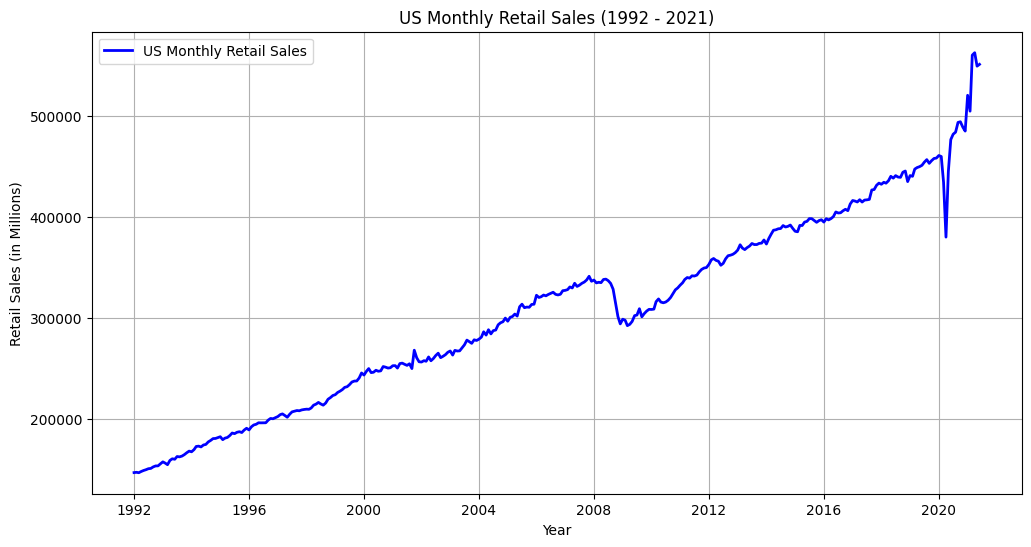

In [5]:
# Now we're ready to plot
import matplotlib.pyplot as plt

# define plot
plt.figure(figsize=(12, 6))
plt.plot(df3.index, df3["SALES"], label="US Monthly Retail Sales", color="blue", linewidth=2)

# format labels
plt.xlabel("Year")
plt.ylabel("Retail Sales (in Millions)")
plt.title("US Monthly Retail Sales (1992 - 2021)")
plt.legend()
plt.grid(True)

plt.show()


The most remarkable downturns are from the '08 crash and the COVID-19 crash. Previous downturns are not as visible per lacking normalization. Retail sales increased steadily throughout the time series until after the quick COVID recovery, when the sales rate spiked beyond the normal growth rate. This could be credited to the federal stimulus provided to consumers and the increased availability of e-commerce outlets.

### Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.

In [6]:
from sklearn.model_selection import train_test_split

# I discovered missing values later on. I'll drop those before creating the split
df3.dropna(inplace=True)

# train/test split on date indices
train = df3[df3.index < "2020-07-01"]
test = df3[df3.index >= "2020-07-01"]

# display shape
train.shape, test.shape


((342, 1), (12, 1))

### Use the training set to build a predictive model for the monthly retail sales.


In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np

# prep data by reshaping 1D array into 2D vector per sklearn requirement
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train["SALES"].values
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_test = test["SALES"].values

# init and train model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

### Use the model to predict the monthly retail sales on the last year of data.


In [8]:
# generate predictions
y_pred = model.predict(X_test)


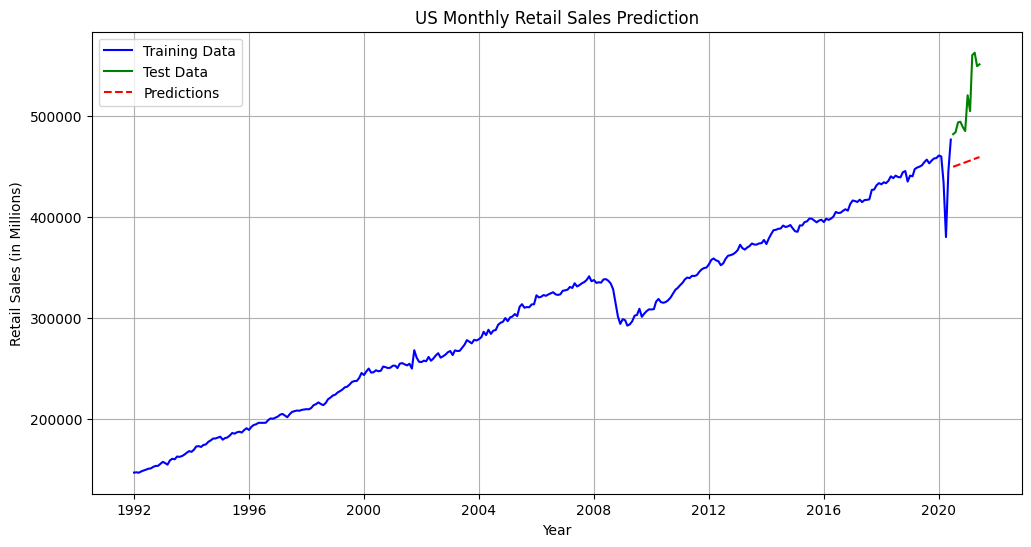

In [9]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["SALES"], label="Training Data", color="blue")
plt.plot(test.index, test["SALES"], label="Test Data", color="green")
plt.plot(test.index, y_pred, label="Predictions", color="red", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Retail Sales (in Millions)")
plt.title("US Monthly Retail Sales Prediction")
plt.legend()
plt.grid(True)
plt.show()


Predictions are biased to the stable increasing rate of the majority of observations before 2020; therefore, the model underpredicts all observations after the July 2020 mark. Model performance may be enhanced by normalizing the data or changing the train/test split, but the uptick in growth is truly unprecedented and difficult to predict with the simple inputs provided.

### Report the RMSE of the model predictions on the test set.


In [10]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 66432.62829228971


Ther error is certainly explained by the predominant success of the training model on the relatively stable older data.